In [1]:
# General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Web Scraping Libraries
import urllib
import requests
from bs4 import BeautifulSoup

# Regex Library
import re

# Time-related Libraries
import time
import datetime

# NLP Libraries
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

# AWS
import logging
import boto3
from botocore.exceptions import ClientError

# Geospatial Libraries
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium


# Helper functions
import MVP_Bojado, MVP_Shi, MVP_Ortiz

# Environment file
import env, env_Shi

import json
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set up universal variables

database = env_Shi.database
library_ds_tech = MVP_Shi.library_ds_tech
library_ds_soft = MVP_Shi.library_ds_soft
library_ds_general = MVP_Shi.library_ds_general
library_wd_tech = MVP_Shi.library_wd_tech
library_wd_soft = MVP_Shi.library_wd_soft
library_wd_general = MVP_Shi.library_wd_general

# Define a class named color
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

## Data Acquisition

<div class="alert alert-block alert-success"><b>All the functions in the Data Acquisitioin section have been tested out and inorporated into the MVP_acquire_ds.py and MVP_acquire_wd.py files. To save space, no extra test is carried out in this notebook.</b></div>

### URL Format of Indeed.com
1. Search chemist in TX<br>
https://www.indeed.com/jobs?q=chemist&l=TX
2. Search chemist in San Antonio, TX<br>
https://www.indeed.com/jobs?q=chemist&l=San+Antonio%2C+TX
3. Search data scientist in San Antonio, TX<br>
https://www.indeed.com/jobs?q=data+scientist&l=San+Antonio%2C+TX
4. Search data scientist intern in San Anotnio, TX<br>
https://www.indeed.com/jobs?q=data+scientist+intern&l=San+Antonio%2C+TX
5. Sort the data scientist jobs posting by date<br>
https://www.indeed.com/jobs?q=data+scientist&l=San+Antonio%2C+TX&sort=date

**Takeaways**
1. q = job title
2. l = location

### URL Format of Monster.com
https://www.monster.com/jobs/search/?q=data-scientist&where=San-Antonio__2C-TX

### Generate the URL of a Job Search at Indeed.com

In [ ]:
def first_page_url_indeed(job_title, location):
    '''
    This function returns a URL of the 1st page of a job search at Indeed.com 
    based on the job title and the location.
    '''
    # Create the base URL for a job serch at Indeed.com
    base_url = 'https://www.indeed.com/jobs?'
    # Create a dictionary to map the keys to the input parameters
    dic = {'q': job_title, 'l': location, 'sort': 'date'}
    # Convert the dictionary to a query string
    relative_url = urllib.parse.urlencode(dic)
    # Generate the full URL of the first page
    url = base_url + relative_url
    return url

### Make the HTTP Request

In [ ]:
def first_page_soup_indeed(job_title, location):
    '''
    This function returns a BeautifulSoup object to hold the content 
    of the first page of a request for job searching at Indeed.com
    '''
    # Generate the URL of the job search based on title and location
    url = first_page_url_indeed(job_title, location)
    # Make the HTTP request
    response = requests.get(url)
    # Print the status code of the request
    print("Status code of the request: ", response.status_code)
    # Sanity check to make sure the document type is HTML
    print("Document type: ", response.text[:15])
    # Take a break
    time.sleep(5)
    # Make a soup to hold the response content
    soup = BeautifulSoup(response.content, "html.parser")
    # Print out the title of the content
    print("Title of the response: ", soup.title.string)
    return soup

In [ ]:
# first_page_soup = first_page_soup_indeed("data scientist", 'al')
# type(first_page_soup)

# # Find out the tag that contains the number of the jobs by seaching

# num_jobs = first_page_soup.find('div', id='searchCountPages')
# print("Data Type: ", type(num_jobs))
# print("Name of the Tag: ", num_jobs.name)
# print("Attributes of the Tag: ", num_jobs.attrs)
# print("Text within the Tag: ")
# num_jobs.text

# # Find the number of the jobs in the text
# match = re.findall(r'(\d+)', num_jobs.text)
# match[1]

In [ ]:
def num_jobs_indeed(first_page_soup):
    '''
    This function returns the total number of the jobs in the searching result.
    '''
    # Find out the section contains total number of jobs  
    div = first_page_soup.find('div', id='searchCountPages')
    # Extract the number
    num_jobs = re.findall(r'(\d+)', div.text)[1]
    return num_jobs

In [ ]:
def page_num_indeed(url):
    '''
    This function returns the page number of job searching results. 
    '''
    # Create a Soup object based on the url
    soup = page_soup_indeed(url)
    # Find out the section contains total number of jobs  
    div = soup.find('div', id='searchCountPages')
    # Extract the number
    page_num = re.findall(r'(\d+)', div.text)[0]
    return page_num

In [ ]:
# Define a function to extract all job cards in a Indeed page

def job_cards_indeed(soup):
    '''
    This function accepts the Soup object of a Indeed page 
    return an iterator containing the all the job cards in this page.
    '''
    # Find the appropriate tag that contains all of the job listings in this page
    tag = soup.find('td', id="resultsCol")
    # Extract all job cards
    job_cards = tag.find_all('div', class_='jobsearch-SerpJobCard')
    return job_cards

In [ ]:
# # Test the function job_cards_indeed
# job_cards = job_cards_indeed(first_page_soup)

# # Print the data type of job_cards
# type(job_cards)

# # How many jobs listed in the 1st page? 
# len(job_cards)

In [ ]:
def job_titles_indeed(job_cards):
    '''
    This function extract the job titles from a job_cards set. 
    '''
    # Create a list to hold the job titles
    titles = []
    # For Loop throught the job cards to extract the titles
    for job in job_cards:
        title = job.find('h2', class_='title')
        title = title.text.strip()
        titles.append(title)
    return titles

In [ ]:
# Define a function to pull the company names from a set of job cards

def company_names_indeed(job_cards):
    '''
    This function extracts the company names from a set of job cards.
    '''
    # Create a list to hold the company names
    names = []
    # For loop through the job cards to pull the company names
    for job in job_cards:
        name = job.find('span', class_='company')
        name = name.text.strip()
        names.append(name)
    return names

In [ ]:
# Define a function to pull the post ages from a set of job cards

def post_ages_indeed(job_cards):
    '''
    This function pulls the post ages from a set of job cards.
    '''
    # Create a list to hold the post ages
    ages = []
    # For loop through the job cards to pull the post ages
    for job in job_cards:
        age = job.find('span', class_='date')
        age = age.text.strip()
        ages.append(age)
    return ages

In [ ]:
# Define a function to pull the location from a set of job cards

def job_locations_indeed(job_cards):
    '''
    This function pulls the job locations from a set of job cards.
    '''
    # Create a list to hold the locations
    locations = []
    # For loop through the job cards to pull the locations
    for job in job_cards:
        location = job.find('div', class_='location accessible-contrast-color-location')
        if location == None:
            location = job.find('span', class_='location accessible-contrast-color-location')
        location = location.text.strip()
        locations.append(location)
    return locations

In [ ]:
# Define a function to pull the company ratings from a set of job cards

def company_rating_indeed(job_cards):
    '''
    This function pulls the company rating from a set of job cards.
    If the rating is unavailable, it will be marked as 'missing'.
    '''
    # Create a list to hold the locations
    ratings = []
    # For loop through the job cards to pull the locations
    for job in job_cards:
        rating = job.find('span', class_='ratingsContent')
        if rating == None:
            ratings.append('missing')
            continue
        rating = rating.text.strip()
        ratings.append(rating)
    return ratings

In [ ]:
def acuqire_indeed_job_description(url):
    '''
    This function accepts the URL of a job posting and pull its description.
    '''
    # Make the HTTP request
    request = requests.get(url)
    print("Status Code: ", request.status_code)
    # Take a break
    time.sleep(5)
    # Make a soup variable holding the response content
    soup = BeautifulSoup(request.content, "html.parser")
    if soup == None:
        description = 'error'
    else:
        # Print the page's title
        print(soup.title.string)
        # Find the section that contains job description
        description = soup.find('div', id="jobDescriptionText")
        if description == None:
            description = 'error'
        else:
            description = description.text
    return description

def job_links_and_contents_indeed(job_cards):
    '''
    This function pulls the job links and descriptions from a set of job cards.
    '''
    # Create a list to hold the links and descriptions
    links = []
    descriptions = []
    # For loop through the job cards to pull the links and descriptions
    for job in job_cards:
        link = job.find('a')['href']
        link = 'https://www.indeed.com' + link
        link = link.replace(';', '&')
        description = acuqire_indeed_job_description(link)
        links.append(link)
        descriptions.append(description)
    return links, descriptions

In [ ]:
# Define a function to create a Soup object based on a job search url

def page_soup_indeed(url):
    '''
    This function returns a BeautifulSoup object to hold the content 
    of a page for a job searching results at Indeed.com
    '''
    # Make the HTTP request
    response = requests.get(url)
    # Print the status code of the request
    print("Status code of the request: ", response.status_code)
    # Sanity check to make sure the document type is HTML
    print("Document type: ", response.text[:15])
    # Take a break
    time.sleep(5)
    # Make a soup to hold the response content
    soup = BeautifulSoup(response.content, "html.parser")
    # Print out the title of the content
    print("Title of the response: ", soup.title.string)
    return soup

In [ ]:
# # Test the function: page_soup_indeed

# url = 'https://www.indeed.com/jobs?q=data+scientist&l=al&sort=date'
# soup = page_soup_indeed(url)
# type(soup)

# # Find out the page number
# int(page_num_indeed(url))

# # Pull the job cards from the soup
# type(job_cards_indeed(soup))

In [ ]:
# Define a function to pull job information from a job search URL

def acquire_page_indeed(url):
    '''
    This function accepts a job search URL and returns a pandas dataframe 
    containing job title, location, company, company rating, post age and description. 
    '''
    # Create a Soup object based on the url
    soup = page_soup_indeed(url)
    # Pull the job cards
    job_cards = job_cards_indeed(soup)
    # Pull the job titles
    titles = job_titles_indeed(job_cards)   
    # Pull the names of the companies
    companies = company_names_indeed(job_cards)
    # Pull the post ages
    ages = post_ages_indeed(job_cards)
    # Pull the job locations
    locations = job_locations_indeed(job_cards)
    # Pull the company ratings
    ratings = company_rating_indeed(job_cards)
    # Pull the hyperlinks and job description
    links, descriptions = job_links_and_contents_indeed(job_cards)    
    # Create a dataframe
    d = {'title': titles,
         'location': locations,
         'company': companies, 
         'company_rating': ratings,
         'post_age': ages, 
         'job_link': links, 
         'job_description': descriptions}
    df = pd.DataFrame(d)
    return df

In [ ]:
def jobs_indeed(job_title, location, max_page=35):
    '''
    This function accepts the job title and location and return the job information (35 pages by default) 
    pulled from Indeed.com.
    '''
    # Generate the urls based on job title and location (state)
    url = first_page_url = first_page_url_indeed(job_title, location)
    # Set up an counter
    counter = 1
    # Create an empty dataframe to hold the job information
    df_jobs = pd.DataFrame(columns = ['title', 'location', 'company', 'company_rating', 
                                      'post_age','job_link', 'job_description'])
    # Pull the page number
    page_num = int(page_num_indeed(url))
    # Set up an checker
    keep_going = (counter == page_num)   
    # For loop through the urls to pull job information
    while keep_going and page_num <= max_page:
        df = acquire_page_indeed(url)
        print("--------------------------------")
        print("Page: ", page_num)
        print("--------------------------------")
        df_jobs = df_jobs.append(df, ignore_index=True)
        df_jobs.to_csv("df_jobs_backup.csv")
        time.sleep(180)
        dic = {'start': page_num*10}
        relative_url = urllib.parse.urlencode(dic)
        url = first_page_url + '&' + relative_url
        counter = counter + 1
        page_num = int(page_num_indeed(url))
        keep_going = (counter == page_num)
    # Print the total number of jobs
    print(f"Total number of {job_title} positions in {location}: ", df_jobs.shape[0])
    return df_jobs

## Data Preparation

### Preparation for Daily Update

<div class="alert alert-block alert-info"><b>The functions defined in this section are used to:</b>
    <ul>
        <li>Compute the date when a job is posted</li>
        <li>Remove the duplicated job postings</li>
        <li>Clean the job titles</li>
        <li>Add new job positings</li>
        <li>Clean the text in the job description</li>
        <li>Delete the redudant columns</li>
        <li>Adjust the data type</li>
        <li>Save as a JSON file for the front end development</li>
     </ul>
</div>

In [3]:
# Define a function to compute the date when the jobs are posted

def compute_post_date(df):
    '''
    This function computes the date of a job posting based on its post age
    and set the date as the index of the dataframe.
    '''
    # Create an empty list to hold the post date
    post_date = []
    # For loop the column post_age and convert the values to date
    for age in df.post_age:
        if age == 'Just posted' or age == 'Today' or age == 'Active today':
            date = datetime.date.today()
            post_date.append(date)
        else:
            # Extract the number
            num = re.findall(r'(\d+)', age)[0]
            # Cast the string number to integer
            num = int(num)
            # Convert the integer to timedelta object
            num = datetime.timedelta(days=num)
            # Compute post date        
            date = datetime.date.today()
            date = date - num
            post_date.append(date)
    # Add post date as new column
    df['date'] = post_date
    # Set the column post_date as the index and sort the values
    df = df.set_index('date').sort_index(ascending=False)
    return df

In [ ]:
# Define a function to transform old job posts files

def transform_old_file(df, date_string):
    '''
    This function accepts old daily job posts and convert the post age to post date. 
    '''
    # Create an empty list to hold the post date
    post_date = []
    # For loop the column post_age and convert the values to date
    for age in df.post_age:
        if age == 'Just posted' or age == 'Today' or age == 'Active today':
            date = datetime.date.fromisoformat(date_string)
            post_date.append(date)
        else:
            # Extract the number
            num = re.findall(r'(\d+)', age)[0]
            # Cast the string number to integer
            num = int(num)
            # Convert the integer to timedelta object
            num = datetime.timedelta(days=num)
            # Compute post date        
            date = datetime.date.fromisoformat(date_string)
            date = date - num
            post_date.append(date)
    # Add post date as new column
    df['date'] = post_date
    # Set the column post_date as the index and sort the values
    df = df.set_index('date').sort_index(ascending=False)
    return df

In [4]:
# Define a function to remove the duplicated job postings

def remove_duplicates(df):
    '''
    This function removes the duplicates in the dataframe based on title, location, 
    company, job_link, and job_description
    '''
    # Define the columns for identifying duplicates
    columns = ['title', 'location', 'company', 'job_link', 'job_description']
    # Drop the duplicates except for the last occurrence
    df.drop_duplicates(subset=columns, inplace=True, keep='last')
    return df

In [5]:
# Define a function to clean the job titles for analysis

def clean_job_title(title):
    '''
    This function removes the "\nnew" and "..." in the job title.
    '''
    title = title.split(sep="\nnew")[0]
#     title = title.split(sep=' -')[0]
#     title = title.split(sep=' (')[0]
#     title = title.split(sep=',')[0]
    title = title.split(sep='...')[0]
    return title

<div class="alert alert-block alert-info"><b>Notes</b>
    <p>1. The locations further break down to city, state, and zipcode in the daily update. According to observations, if the values in the city and zipcode columns are missing, the jobs are in remote.</p>
    <p>2. Nearly 20% company do not have ratings. The missing values are replaced with the mean of the company rating.</p>
    <p>3. 3.3% of the job postings has no description.</p>
    </div>

In [6]:
# Define a function to add the new job new postings

def daily_update(df_new):
    '''
    This function updates and prepares the job posts by adding daily new job postings 
    and save as JSON file. 
    '''
    # Load the job posts based on the inputted job title
    database = env_Shi.database
    print("Enter the INITIALS of the job title:")
    initials = input()
    df = pd.read_csv(f"{database}df_{initials}_tx_backup.csv")
    num_jobs = df.shape[0]
    # Convert the date column to datetime type
    df.date = pd.to_datetime(df.date)
    # Set the date column as the index and sort the index
    df = df.set_index('date').sort_index(ascending=False)
    
    # Add the new job postings
    df_new = compute_post_date(df_new)
    df = pd.concat([df, df_new]).sort_index(ascending=False)
    
    # Remove the duplicates
    df = remove_duplicates(df)
    
    # Back up the jop postings as a csv file before data cleaning phase I
    df.to_csv(f"{database}df_{initials}_tx_backup.csv")
    num_new_jobs = df.shape[0] - num_jobs
    print("New Jobs of Posted Today: ", num_new_jobs)
    
    # Re-Load the dataset
    df = pd.read_csv(f"{database}df_{initials}_tx_backup.csv")
    
    # Clean the location data: break the location to city, state, and zipcode
    location = df.location.str.split(', ', expand=True)
    location.columns = ['city', 'zipcode']
    # Imputation
    location.city = location.city.apply(lambda i: 'Remote' if i == 'United States' else i)
    location.city = location.city.apply(lambda i: 'Remote' if i == 'Texas' else i)
    location.zipcode = location.zipcode.apply(lambda i: 0 if re.findall(r"(\d+)", str(i)) == [] 
                                              else re.findall(r"(\d+)", str(i))[0])
    df['city'] = location.city
    df['state'] = 'TX'
    df['zipcode'] = location.zipcode
    
    # Replace the missing values in the company rating with the mean
    df.company_rating = df.company_rating.replace('missing', np.NaN).astype(float)
    mean_rating = df.company_rating.mean()
    df.company_rating.fillna(mean_rating, inplace=True)
    df.company_rating = df.company_rating.round(2)
    
    # Clean the text in the job description
    df = MVP_Bojado.prep_job_description_data(df, 'job_description')
    
    # Clean the job title
    df.title = df.title.apply(clean_job_title)
    
    # Drop the redundant columns post_age and location
    redundant_cols = ['post_age', 'location', 'tokenized', 'stemmed', 'lemmatized']
    df = df.drop(columns=redundant_cols)
    
    # Alther the data type of zipcode
    df.zipcode = df.zipcode.apply(lambda i: int(i))
    
    # Save a JSON version of the prepared data
    df.to_json(f"{database}df_{initials}_tx_prepared_backup.json", orient='records')
    return df

<div class="alert alert-block alert-info"><b>Notes:</b>
    <p>1. When a dataframe with datetime index is saved as a csv file by default and then loaded again in the notebook, the datetime index is converted to a column and its data type is object. Then the new dataframe is saved as json file and then loading the json in the notebook, the datatype of the date is converted back to datetime64.<p>
    <p>2. When a datetime object column is saved as in json, the datetime will be represented a series of number.</p>
    <p>3. Detailed physical address can't be found on the Indeed website. It has to be obtained through other approaches.</p> 
    </div>

In [ ]:
# # Load job posts of web developer in TX on Feb.12 2021

# # Import the file path
# database = env_Shi.database

# # Read the daily data scientist jobs in TX
# df_wd_old = pd.read_csv(f"{database}web_developer_tx_indeed_021221.csv", index_col=0)

# # Print the first 2 rows
# df_wd_old.head(2)

# # Transform old file
# df_wd_old = transform_old_file(df_wd_old, '2021-02-12')
# df_wd_old.head(2)

### Daily Update of Job Postings of Data Scientist and Web Developer Positions in TX

In [11]:
# Load the job postings in TX on March 12 2021

# Read the daily job postings
print("Enter FULL NAME of the job title in ALL lowercase: ")
job_title = input()
print("Enter the date in the format mmddyy")
date = input()
job_title = job_title.split()
df_new = pd.read_csv(f"{database}{job_title[0]}_{job_title[1]}_tx_indeed_{date}.csv", index_col=0)

# Print the dimentionality
print(df_new.shape)

# Print the first 5 rows
df_new.head(5)

Enter FULL NAME of the job title in ALL lowercase: 
web developer
Enter the date in the format mmddyy
061521
(225, 7)


,title,location,company,company_rating,post_age,job_link,job_description
0,Web Application Developer\nnew,"Dallas-Fort Worth, TX",Talus Payments,3.0,Just posted,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Job Description:Talus payments is seeking a ta...
1,Web Application/Reporting Developer Level – I ...,"Austin, TX 78701 (Downtown area)","OroSolutions, LLC",missing,Just posted,"https://www.indeed.com/company/Orosolutions,-L...",Company Profile: Our primary focus is providi...
2,Software Engineer - Remote\nnew,"Dallas, TX 75229 (Preston Hollow area)",Allscripts,3.6,Just posted,https://www.indeed.com/rc/clk?jk=636f80c854b1c...,Welcome to Allscripts! Our Mission is to be th...
3,"Web Development Sales Lead - Flexible, Remote\...","McAllen, TX",Buddy Web Design & Development,missing,Just posted,https://www.indeed.com/company/Buddy-Web-Desig...,"Looking to be part of, and help grow, an excel..."
4,React JS Developer\nnew,"Irving, TX",Vegazva,missing,Just posted,https://www.indeed.com/company/Vegazva/jobs/Re...,Job title: React JS DeveloperLocation: Irvin...


In [12]:
%%time
# Perform the daily updates

df_current = daily_update(df_new)
df_current.head(5)

Enter the INITIALS of the job title:
wd
New Jobs of Posted Today:  130
CPU times: user 2min 36s, sys: 1.54 s, total: 2min 38s
Wall time: 2min 40s


,date,title,company,company_rating,job_link,job_description,city,state,zipcode,clean
0,2021-06-15,Web Application Developer,Talus Payments,3.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Job Description:Talus payments is seeking a ta...,Dallas-Fort Worth,TX,0,job descriptiontalus payment seeking talented ...
1,2021-06-15,Staff Software Engineer,The Home Depot,3.8,https://www.indeed.com/cmp/The-Home-Depot,error,Austin,TX,0,error
2,2021-06-15,Info Security Sr Engineer - Malicious Code Res...,Wells Fargo,3.7,https://www.indeed.com/rc/clk?jk=b2b1cd2b9fca8...,Job Description\nImportant Note: During the ap...,San Antonio,TX,0,job description important note application pro...
3,2021-06-15,Sr. Net Developer,Softvision,3.7,https://www.indeed.com/rc/clk?jk=0faede86a17d8...,WE ARE A TRANSFORMATIONAL PARTNER\nWe marry de...,Dallas,TX,0,transformational partner marry design engineer...
4,2021-06-15,Sr Software Engineer,Consolidated Analytics,3.6,https://www.indeed.com/rc/clk?jk=3b2a6d61ecd01...,"Job Description: Local Candidates Only\n\n""6+ ...",Coppell,TX,0,job description local candidate 6 year experie...


In [13]:
# Print the information of the dataframe
df_current.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12285 entries, 0 to 12284
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             12285 non-null  object 
 1   title            12285 non-null  object 
 2   company          12285 non-null  object 
 3   company_rating   12285 non-null  float64
 4   job_link         12285 non-null  object 
 5   job_description  12285 non-null  object 
 6   city             12285 non-null  object 
 7   state            12285 non-null  object 
 8   zipcode          12285 non-null  int64  
 9   clean            12285 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 959.9+ KB


In [14]:
# Define the columns for identifying duplicates
columns = ['date', 'title', 'company', 'job_link', 'job_description', 'city', 'state', 'zipcode']
   
# Check for duplicates
duplicates = df_current.duplicated(subset=columns,keep='last')
duplicates.sum()

1211

<div class="alert alert-block alert-info"><b>Takeaways:</b>
After the job titles are cleaned, the duplicates of job postings starts to appear. It suggests that when the same job is re-posted, the job title changes. 
</div>

In [ ]:
# # Read the json file

# result = open(f"{database}df_wd_tx_prepared_backup.json")
# parsed = json.load(result)
# parsed[1]

### Upload Prepared JSON Files to AWS S3 Bucket

In [ ]:
# %%time
# # Upload the json file to AWS

# # Create the s3 resource object
# s3 = boto3.resource('s3')

# # Create the job title initials
# print("Enter the INITIALS of the job title:")
# initials = input()

# # Upload df_ds_tx_backup.csv file
# s3.Bucket(f'{initials}rawjobpostings').upload_file(f"{database}df_{initials}_tx_backup.csv", 
#                                                    f"df_{initials}_tx_backup.csv")

# # Upload df_ds_tx_prepared_backup.json file
# s3.Bucket(f'{initials}preparedjobpostings').upload_file(f"{database}df_{initials}_tx_prepared_backup.json", 
#                                                         f"df_{initials}_tx_prepared_backup.json")

## Data Exploration

<div class="alert alert-block alert-info"><b>In this section, the data in the job postings are further explored in the following areas.</b>
    <ul>
        <li>Geospacial analysis</li>
        <li>Text analysis</li>
        <li>Time aeries analysis</li>
        <li>More...</li>
    </ul>
    </div>

### Acquire the Prepared Dataset From AWS S3

#### List All Buckets in S3

In [ ]:
# # Create the s3 resource object
# s3 = boto3.resource('s3')   # Notes: the datatype of s3 is s3.ServiceResource

# # Print the bucket names
# print(color.UNDERLINE + color.BOLD + "List of Buckets in S3:" + color.END)
# for bucket in s3.buckets.all():
#     print(bucket.name)

#### List All the Files in a Bucket

In [ ]:
# # Input the name of the bucket
# bucket_name = input()

# # Create the bucket object
# bucket = s3.Bucket(bucket_name) # Note: the data type of the bucket is s3.Bucket

# # List all the files inside the bucket

# print(color.UNDERLINE + color.BOLD + f"List of Files in Bucket {bucket_name}:" + color.END)
# for page in bucket.objects.pages():
#     for obj in page:
#         print(obj.key)

#### Check the Last Modified Datetime for the Prepared JSON Files

In [ ]:
# # Print the time when the prepared json file is last modified

# s3 = boto3.resource("s3")
# prepared_json = s3.Object('dspreparedjobpostings', 'df_ds_tx_prepared_backup.json')
# print("Last modified time of JSON for data scientist position: ", prepared_json.last_modified)

In [ ]:
# # When is the df_wd_tx_prepared.json last modified?

# s3 = boto3.resource('s3')
# prepared_json = s3.Object('wdpreparedjobpostings', 'df_wd_tx_prepared_backup.json')
# print("Last modified time of JSON for web developer position: ", prepared_json.last_modified)

#### Down Load JSON Files from AWS

In [ ]:
# # Download JSON file from AWS 
# database = env_Shi.database
# s3.Bucket('dsrawjobpostings').download_file('df_ds_tx_backup.csv', 
#                                             f"{database}df_ds_tx_aws.csv")

### Acquire the Prepared Job Postings of Data Science Positions from the Local Database

In [3]:
# Define a function to load JSON file of job postings

def read_job_postings_json():
    '''
    This function reads the JSON file of prepared job postings into a pandas dataframe 
    based on a job title and set the date as the index.
    '''
    # Load the file path of the local database
    database = env_Shi.database
    # Create the file name
    print("Enter the INITIALS of the job title:")
    initials = input()
    file_name = 'df_' + initials + '_tx_prepared_backup.json'
    
    # Read the JSON file into a pandas dataframe
    df = pd.read_json(f'{database}{file_name}')
    # Print the numbr of job posts
    print("Number of Job Postings To Date: ", df.shape[0])
    
    # Ask: do you need to set the date as the index? 
    print("Do you want to set the date as the index? (Y/N)")
    answer = input()
    if answer == 'Y' or answer == 'y':
        # Convert the string date to datetime
        df.date = pd.to_datetime(df.date)
        # Set the date as the index and sort the dataframe
        df = df.set_index('date').sort_index(ascending=False)
    elif answer == 'N' or answer == 'n':
            print("You can manually set it up later or re-run this function.")
    return df

In [4]:
# Load the job postings for the data scientists
df_ds_tx = read_job_postings_json()

# Print the first 5 rows of the dataframe
df_ds_tx.head()

Enter the INITIALS of the job title:
ds
Number of Job Postings To Date:  6126
Do you want to set the date as the index? (Y/N)
y


,title,company,company_rating,job_link,job_description,city,state,zipcode,clean
date,,,,,,,,,
2021-06-15,Data Scientist,Aquent,4.00,https://www.indeed.com/cmp/Aquent,error,West,TX,0,error
2021-06-15,Painter - Austin Industrial (NLP),Noltex Cap,3.78,https://www.indeed.com/rc/clk?jk=55399a4fc1689...,Painter\nEssential Job Duties\nPrepares wood a...,La Porte,TX,0,painter essential job duty prepares wood metal...
2021-06-15,Data Scientist,Texas Research International Inc,3.80,https://www.indeed.com/rc/clk?jk=2190f68e7da24...,Description:\nThe Role: Data Scientist\nThe Lo...,Austin,TX,78733,description role data scientist location remot...
2021-06-15,Vessel Tracking & Alternative Data Lead,"LUKOIL Pan Americas, LLC",3.78,https://www.indeed.com/rc/clk?jk=59adec4168b81...,Description:\n\nSummary\nThe primary purpose o...,Houston,TX,77098,description summary primary purpose position s...
2021-06-15,Data Science Brand Technical Specialist,IBM,3.90,https://www.indeed.com/rc/clk?jk=3d1b46b9910e8...,Introduction\nClient Technical Specialists (CT...,Austin,TX,73301,introduction client technical specialist ctp t...


In [5]:
df_ds_tx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6126 entries, 2021-06-15 to 2020-12-22
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            6126 non-null   object 
 1   company          6126 non-null   object 
 2   company_rating   6126 non-null   float64
 3   job_link         6126 non-null   object 
 4   job_description  6126 non-null   object 
 5   city             6126 non-null   object 
 6   state            6126 non-null   object 
 7   zipcode          6126 non-null   int64  
 8   clean            6126 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 478.6+ KB


In [121]:
# mask = df_ds_tx.loc['2021-06-09'].title == 'Data Scientist'
# mask = df_ds_tx.loc['2021-06-02'].city == 'San Antonio'
# mask = df_ds_tx.loc['2021-06-02'].company == 'American Airlines'
# df = df_ds_tx.loc['2021-06-09'][mask]
df = df_ds_tx.loc['2021-06-07'].iloc[-1]
df

title              Healthcare Data Scientist - Watson Health Fede...
company                                                          IBM
company_rating                                                   3.9
job_link           https://www.indeed.com/rc/clk?jk=c2a250b10984d...
job_description    Introduction\nAs a Data Scientist at IBM, you ...
city                                                          Austin
state                                                             TX
zipcode                                                        73301
clean              introduction data scientist ibm help transform...
Name: 2021-06-07 00:00:00, dtype: object

In [122]:
df.job_link

'https://www.indeed.com/rc/clk?jk=c2a250b10984de7d&fccid=de71a49b535e21cb&vjs=3'

In [6]:
# Load the job postings for web developers
df_wd_tx = read_job_postings_json()

# Print the first 5 rows of the dataframe
df_wd_tx.head()

Enter the INITIALS of the job title:
wd
Number of Job Postings To Date:  12285
Do you want to set the date as the index? (Y/N)
y


,title,company,company_rating,job_link,job_description,city,state,zipcode,clean
date,,,,,,,,,
2021-06-15,Web Application Developer,Talus Payments,3.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Job Description:Talus payments is seeking a ta...,Dallas-Fort Worth,TX,0,job descriptiontalus payment seeking talented ...
2021-06-15,Staff Software Engineer,The Home Depot,3.8,https://www.indeed.com/cmp/The-Home-Depot,error,Austin,TX,0,error
2021-06-15,Info Security Sr Engineer - Malicious Code Res...,Wells Fargo,3.7,https://www.indeed.com/rc/clk?jk=b2b1cd2b9fca8...,Job Description\nImportant Note: During the ap...,San Antonio,TX,0,job description important note application pro...
2021-06-15,Sr. Net Developer,Softvision,3.7,https://www.indeed.com/rc/clk?jk=0faede86a17d8...,WE ARE A TRANSFORMATIONAL PARTNER\nWe marry de...,Dallas,TX,0,transformational partner marry design engineer...
2021-06-15,Sr Software Engineer,Consolidated Analytics,3.6,https://www.indeed.com/rc/clk?jk=3b2a6d61ecd01...,"Job Description: Local Candidates Only\n\n""6+ ...",Coppell,TX,0,job description local candidate 6 year experie...


### Breif Summary

#### Data Scientist Positions

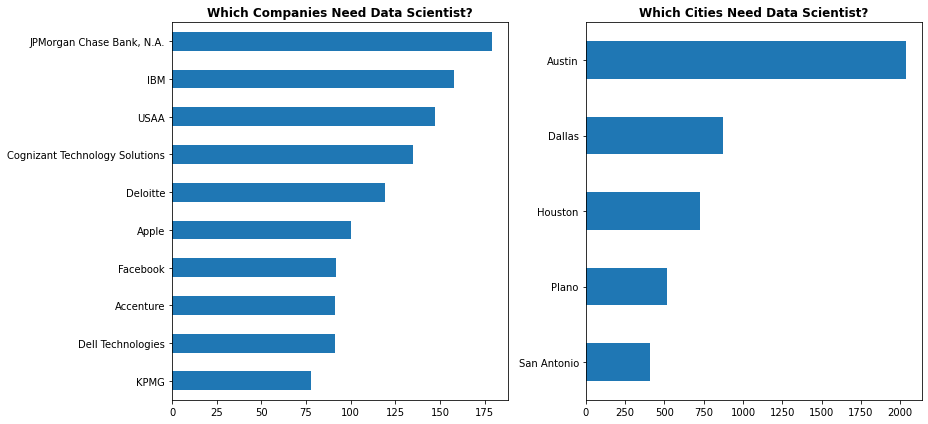

In [7]:
# Barplot the top 10 companies and top 5 cities by the number of the job posts

plt.figure(figsize=(13,6))

plt.subplot(121)
top_companies = df_ds_tx.company.value_counts().head(10)
top_companies.sort_values().plot(kind='barh')
plt.title("Which Companies Need Data Scientist?", fontweight='bold')

plt.subplot(122)
top_cities = df_ds_tx.city.value_counts().head(5)
top_cities.sort_values().plot(kind='barh')
plt.title("Which Cities Need Data Scientist?", fontweight='bold')

plt.tight_layout()
plt.show()

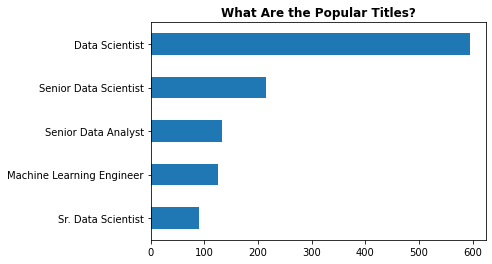

In [8]:
# Barplot the popular titles of the job postings

top_title = df_ds_tx.title.value_counts().head(5)
top_title.sort_values().plot(kind='barh')
plt.title("What Are the Popular Titles?", fontweight='bold')

plt.show()

### Geospacial Analysis

In [ ]:
# Check the data types of the df_ds_tx
df_ds_tx.info()

In [ ]:
# Generate a copy and add the city_state column

df_ds_tx_copy = df_ds_tx.copy()
df_ds_tx_copy = df_ds_tx_copy.assign(city_state = 
                                     df_ds_tx_copy['city'] + ', ' + df_ds_tx_copy['state'])

df_ds_tx_copy.info()

In [ ]:
%%time
# Generate coordinates for all the citys in the df_ds_tx

df_coordinates = MVP_Ortiz.get_geodata(df_ds_tx_copy)
print("Number of cities: ", df_coordinates.shape[0])
df_coordinates.head()

In [ ]:
# # Save as the json and upload to AWS s3 bucket

# file_name = "geospatial_data.json"
# df_coordinates.to_json(f"{database}{file_name}", orient="records")

# # Upload to AWS S3 bucket
# s3 = boto3.resource('s3')
# s3.Bucket("additionaljobinfo").upload_file(f"{database}{file_name}", file_name)

In [ ]:
# # Add coordinates to the original dataframe
# df_ds_tx_copy = df_ds_tx_copy.merge(df_coordinates, how='left', on='city_state')
# df_ds_tx_copy.info()

<div class="alert alert-block alert-info"><b>Notes:</b><br>
    The rows may be re-sorted according to key order when two dataframes are merged, depending on what type of merge is performed.<br>
    If joining columns on column, the dataframe indexes will be ignored.
    </div>

In [ ]:
# # Convert the date to string date
# df_ds_tx_copy.date = df_ds_tx_copy.date.apply(lambda i: i.strftime("%Y-%m-%d"))

In [ ]:
# df_ds_tx_copy.info()

In [ ]:
# # Save as the JSON file for data visualization and analysis in Tableau
# df_ds_tx_copy.to_json(f"{database}df_ds_tx_tableau.json", orient="records")

### Text Analysis

In [9]:
# Define the function to create the words that appear in the job descriptions

def words_variables_v1(df):
    '''
    This function accepts the dataframe with cleaned job description 
    and return a dictionary in which the values are the words that 
    appear in the job description. 
    '''
    # Create the words that appear all the job descritipons
    all_words = ' '.join(df.clean)
    # Create a dictionary to hold the variable all_words
    d_words = {'frequency': all_words}
    return d_words

In [10]:
# Upgrade the function `words_variables_v1`

def words_variables_v2(df, companies):
    '''
    This function accepts the dataframe containing cleaned job description and 
    a list of company names and return a dictionary in which the values are the words 
    that appear in the job description. 
    '''
    # Create the words that appear all the job descritipons
    all_words = ' '.join(df.clean)
    # Create a dictionary to hold the variable all_words
    d_words = {'all': all_words}
    # For loop the companies and create the words that appear in their job descriptions
    for company in companies:
        mask = (df.company == company)
        s_company = df[mask].clean
        words = ' '.join(s_company)
        d_words[company] = words
    return d_words

In [11]:
# Create the words variable
d_words = words_variables_v1(df_ds_tx)

# Print the first characters in the words variable
d_words['frequency'][:100]

'error painter essential job duty prepares wood metal surface painting paint equipment part machinery'

In [12]:
# Define a function to compute the frequence of the mono-, bi-, and tri-grams of the job description

def everygram_frequency_v1(d_words, max_len=3):
    '''
    This function accetps the dictionary produced by the function `words_variables_v1` and 
    return mono-, bi-, and tri-grams along with their frequency. 
    '''
    # Generate mono-, bi-, and tri-grams
    grams = nltk.everygrams(d_words['frequency'].split(), max_len=max_len) # dtype of grams: <class 'genertor'>
    # Convert to a list of tuples
    grams = list(grams)
    # Create an empty list to hold mono-, bi-, and tri-grams
    everygram = []
    # For loop the list of tuples and convert the grams to strings
    for gram in grams:
        str_gram = gram[0]
        for i in gram[1:]:
            str_gram = str_gram + ' ' + i
        everygram.append(str_gram)
    # Compute the frequency of the everygrams
    everygram = pd.Series(everygram).value_counts()
    return everygram

In [13]:
%%time

# Compute the frequency of mono-, bi-, and tri-grams
gram_frequency = everygram_frequency_v1(d_words)

# Print the top 5 most frequent word(s)
gram_frequency.head()

CPU times: user 7.36 s, sys: 790 ms, total: 8.14 s
Wall time: 8.21 s


data          60783
experience    35483
business      24050
team          21064
work          18722
dtype: int64

### Compute the Top 10 Skills for Data Scientists in TX

In [14]:
# Define a function to pick up the top k skills from a skill library

def top_skills_v1(df, k, library):
    '''
    This function accepts a positive integer k and a skillset library and 
    returns a dataframe containing the top k skills needed for data scientist positions.
    '''
    # Confirm library type
    print("Please confirm library type: general or tech or soft?")
    library_type = input()
    # Create a string of all words that appear in the job description
    dic = words_variables_v1(df)
    # Compute the words frequency
    everygram_frequency = everygram_frequency_v1(dic)
    # Create a empty dataframe to hold the rank of the skills
    df_skills = pd.DataFrame()
    # For loop through the library to find out the frequency of the skills mentioned in the job description
    for skill in library:
        mask = (everygram_frequency.index == skill)
        df =  everygram_frequency[mask]
        df_skills = pd.concat([df_skills, df])
    df_skills.columns = dic.keys()
    df_skills.sort_values(by='frequency', ascending=False, inplace=True)
    # Reset the index
    df_skills.reset_index(inplace=True)
    # Rename the column name
    df_skills.rename(columns={'index': f'top{k}_{library_type}_skills'}, inplace=True)
    return df_skills.head(k)

In [15]:
# Print the number of skills in the tech library
print("Number of skills in tech skill library: ", len(library_ds_tech))

# Compute top 10 technical skills for data scientist position in TX
df_ds_top_tech = top_skills_v1(df_ds_tx, 10, library_ds_tech)
df_ds_top_tech

Number of skills in tech skill library:  71
Please confirm library type: general or tech or soft?
tech


,top10_tech_skills,frequency
0,machine learning,9602.0
1,python,5237.0
2,sql,3796.0
3,r,2735.0
4,aws,2512.0
5,big data,2097.0
6,spark,1824.0
7,deep learning,1750.0
8,azure,1567.0
9,hadoop,1494.0


In [16]:
# Print the number of skills in the soft library
print("Number of skills in soft skill library: ", len(library_ds_soft))

# Compute top 10 soft skills for data scientists in TX
df_ds_top_soft = top_skills_v1(df_ds_tx, 10, library_ds_soft)
df_ds_top_soft

Number of skills in soft skill library:  19
Please confirm library type: general or tech or soft?
soft


,top10_soft_skills,frequency
0,communication,4089.0
1,leadership,3010.0
2,collaboration,1403.0
3,problem solving,787.0
4,decision making,664.0
5,written communication,579.0
6,verbal communication,511.0
7,curiosity,336.0
8,business acumen,332.0
9,creativity,327.0


In [17]:
# Print the number of skills in the soft library
print("Number of skills in soft skill library: ", len(library_ds_general))

# Compute top 10 soft skills for data scientists in TX
df_ds_top_general = top_skills_v1(df_ds_tx, 10, library_ds_general)
df_ds_top_general

Number of skills in soft skill library:  89
Please confirm library type: general or tech or soft?
general


,top10_general_skills,frequency
0,machine learning,9602.0
1,python,5237.0
2,communication,4089.0
3,sql,3796.0
4,leadership,3010.0
5,r,2735.0
6,aws,2512.0
7,big data,2097.0
8,spark,1824.0
9,deep learning,1750.0


### Compute Top 10 Skills for Web Developers

In [18]:
# Print the number of skills in the tech library
print("Number of skills in tech skill library: ", len(library_wd_tech))

# Compute top 10 technical skills for web developers in TX
df_wd_top_tech = top_skills_v1(df_wd_tx, 10, library_wd_tech)
df_wd_top_tech

Number of skills in tech skill library:  65
Please confirm library type: general or tech or soft?
tech


,top10_tech_skills,frequency
0,javascript,9644.0
1,java,6258.0
2,sql,5790.0
3,react,5389.0
4,c,4850.0
5,net,4690.0
6,html,4332.0
7,angular,4240.0
8,aws,3964.0
9,ui,3731.0


In [19]:
# Print the number of skills in the soft library
print("Number of skills in soft skill library: ", len(library_wd_soft))

# Compute top 5 soft skills for web devlopers in TX
df_wd_top_soft = top_skills_v1(df_wd_tx, 10, library_wd_soft)
df_wd_top_soft

Number of skills in soft skill library:  19
Please confirm library type: general or tech or soft?
soft


,top10_soft_skills,frequency
0,communication,7243.0
1,leadership,2702.0
2,collaboration,2018.0
3,problem solving,1376.0
4,written communication,1092.0
5,verbal communication,792.0
6,team player,781.0
7,teamwork,612.0
8,creativity,521.0
9,time management,447.0


In [20]:
# Print the number of skills in the soft library
print("Number of skills in soft skill library: ", len(library_wd_general))

# Compute top 5 soft skills for web developers in TX
df_wd_top_general = top_skills_v1(df_wd_tx, 10, library_wd_general)
df_wd_top_general

Number of skills in soft skill library:  84
Please confirm library type: general or tech or soft?
general


,top10_general_skills,frequency
0,javascript,9644.0
1,communication,7243.0
2,java,6258.0
3,sql,5790.0
4,react,5389.0
5,c,4850.0
6,net,4690.0
7,html,4332.0
8,angular,4240.0
9,aws,3964.0


### Time Series Analysis
- Centered on Skills

In [21]:
# Define a function to compute the frequencies of the top 5 skills in each observation

def top_skill_frequency(df, df_top):
    '''
    This function accepts the dataframe of the prepared job postings and the top k skills and provides
    three options: 
    - to save the frequencies of the top skills over time as a JSON file and upload to AWS.
    - to return a dataframe containing only the frequecies of the top skills over time.
    - to add the frequencies of the top skills over time to the original dataframe
    - to save the merged dataframe as JSON file in the database. 
    '''
    # Reminder
    print("Please insure the date is in the right format")
    
    # Confirm the library type
    print("Confirm TYPE of library: tech or soft or general")
    library_type = input()

    # Confirm the job title
    print("Enter the INITIALS of the job title:")
    initials = input()
    
    # Create a list of the top k skills
    skill_list = df_top.iloc[:, 0].to_list()
    
    # Create an empty dictionary to hold the frequency of the skill in each observation
    dic_frequency = {}    
    # Loop through the list of skills to compute its frequency in each observation
    for skill in skill_list:
        list_frequency = []
        for string in df.clean.values:
            matches = re.findall(f" {skill} ", string)
            frequency = len(matches)
            list_frequency.append(frequency)
        dic_frequency[skill]=list_frequency
        
    # Convert the dictionary into the dataframe and set the index the same as df
    df_frequency = pd.DataFrame(dic_frequency, index=df.index)
    
    # Save as JSON file and upload to AWS
    print("Do you want to save the dataframe as JSON and upload to AWS? (Y/N)")
    save_option = input()
    if save_option == "Y" or save_option == 'y':
        df_freq_copy = df_frequency.reset_index()
        df_freq_copy.date = df_freq_copy.date.apply(lambda i: i.strftime("%Y-%m-%d"))
        database = env_Shi.database
        file_name = f"{initials}_top_{library_type}_ts.json"
        df_freq_copy.to_json(f"{database}{file_name}", orient="records")
        s3 = boto3.resource("s3")
        s3.Bucket("additionaljobinfo").upload_file(f"{database}{file_name}", file_name)
    elif save_option == "N" or save_option == 'n':
        print("You can manually save it by yourself")
        
    # Merge two dataframe together
    print("Do you want to merge the dataframes? (Y/N)")
    merge_option = input()
    if merge_option == "Y" or merge_option == 'y':
        df_frequency = pd.concat([df, df_frequency], axis=1)
        
        # Save the merged dataframe as JSON
        print("Do you want to save the merged dataframe? (Y/N)")
        save_option = input()
        if save_option == 'Y' or save_option == 'y':
            df_freq_copy = df_frequency.reset_index()
            df_freq_copy.date = df_freq_copy.date.apply(lambda i: i.strftime("%Y-%m-%d"))
            database = env_Shi.database
            file_name = f"df_{initials}_tx_top_{library_type}_ts.json"
            df_freq_copy.to_json(f"{database}{file_name}", orient="records")
        elif save_option == 'N' or save_option == 'n':
            print("You can manually save it by yourself")

    elif merge_option == "N" or merge_option == 'n':
        print("You can manually merge it by yourself")
    
    return df_frequency

In [28]:
%%time

df_test = top_skill_frequency(df_wd_tx, df_wd_top_soft)
df_test.head()

Please insure the date is in the right format
Confirm TYPE of library: tech or soft or general
soft
Enter the INITIALS of the job title:
wd
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
n
You can manually save it by yourself
Do you want to merge the dataframes? (Y/N)
y
Do you want to save the merged dataframe? (Y/N)
y
CPU times: user 1.08 s, sys: 129 ms, total: 1.21 s
Wall time: 11.1 s


,title,company,company_rating,job_link,job_description,city,state,zipcode,clean,communication,leadership,collaboration,problem solving,written communication,verbal communication,team player,teamwork,creativity,time management
date,,,,,,,,,,,,,,,,,,,
2021-06-15,Web Application Developer,Talus Payments,3.0,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Job Description:Talus payments is seeking a ta...,Dallas-Fort Worth,TX,0,job descriptiontalus payment seeking talented ...,1,0,1,0,0,0,0,0,0,0
2021-06-15,Staff Software Engineer,The Home Depot,3.8,https://www.indeed.com/cmp/The-Home-Depot,error,Austin,TX,0,error,0,0,0,0,0,0,0,0,0,0
2021-06-15,Info Security Sr Engineer - Malicious Code Res...,Wells Fargo,3.7,https://www.indeed.com/rc/clk?jk=b2b1cd2b9fca8...,Job Description\nImportant Note: During the ap...,San Antonio,TX,0,job description important note application pro...,1,0,1,2,1,0,0,0,0,0
2021-06-15,Sr. Net Developer,Softvision,3.7,https://www.indeed.com/rc/clk?jk=0faede86a17d8...,WE ARE A TRANSFORMATIONAL PARTNER\nWe marry de...,Dallas,TX,0,transformational partner marry design engineer...,1,0,0,0,1,0,1,0,0,0
2021-06-15,Sr Software Engineer,Consolidated Analytics,3.6,https://www.indeed.com/rc/clk?jk=3b2a6d61ecd01...,"Job Description: Local Candidates Only\n\n""6+ ...",Coppell,TX,0,job description local candidate 6 year experie...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def plot_top_skill_ts(df, df_top):
    '''
    This function accetps the dataframe of preapred job postings with the frequencies of the skills
    and plot how popular each skill changes over time. 
    '''
    # Set up the size of the plot
    plt.figure(figsize=(11, 8))
    # Create a list of the top skills
    skill_list = df_top.iloc[:, 0].to_list()
    # Resample the dataset by week and plot the mean of the frequency of each skill per job posting
    for skill in skill_list:
        df.resample('W')[skill].mean().plot(label=f'{skill} Weekly')
    
    # Name the plot
    plt.title("How Popular the Top 5 Skills Are Over Time", fontweight='bold')
    # Position the legend
    plt.legend(bbox_to_anchor=(1, 1))

In [ ]:
plot_top_skill_ts(df_ds_tx, df_ds_top_tech)

### Skills Match Job Search

In [ ]:
# Define a function to find the job position that match the skills of a applicant

def skills_match_search(skills):
    '''
    '''  
    # Create the initials of the job_title
    print("Enter the INITIALS of the job title:")
    initials = input()
    # Load the file path
    database = env_Shi.database
    # Create the file name
    file_name = 'df_' + initials + '_tx_prepared_backup.json'
    # Load the job postings file
    df = pd.read_json(f'{database}{file_name}')
    # Create a list variable to hold the boolean values
    mask = []
    # For loop 
    for clean in df.clean:
        if all(skill in clean for skill in skills):
            mask.append(True)
        else:
            mask.append(False)
    df_match = df[mask]
    cols = ['job_description', 'clean']
    df_match.drop(columns=cols, inplace=True)
    print("Number of the Matched Companies: ", df_match.shape[0])
    return df_match

In [ ]:
# Define the skillset I own
skills = ['python', 'sql', 'tableau']

df_search = skills_match_search(skills)
df_search.shape

In [ ]:
mask = (df_search.title == 'Data Scientist')
df_search = df_search[mask]
df_search.shape

In [ ]:
i = 6

print(df_search.job_link.iloc[i])

df_search.iloc[i]

In [ ]:
# Create the masks for different skills

mask_python = df_ds_tx.clean.str.contains('python')
mask_sql = df_ds_tx.clean.str.contains('sql')
mask_ml = df_ds_tx.clean.str.contains('machine learning')
mask_tableau = df_ds_tx.clean.str.contains('tableau')
mask_aws = df_ds_tx.clean.str.contains('aws')

mask = mask_python & mask_sql & mask_tableau & mask_aws

In [ ]:
# How many companies need all three skills: python, sql and tableau
mask.sum()

In [ ]:
df_ds_tx[mask].head(1)

In [ ]:
df_ds_tx.clean[0][:100]